### Load Libraries & Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pickle
import matplotlib.pyplot as plt
import time

### Import Data and State-Space Model

In [2]:
with open('3_grey-box-modelling_data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'] # indoor air temperature in degC
To = Data['To'] # outdoor air temperature in degC
# q_HVAC = Data['q_HVAC'] # HVAC heating rate in W
q_solar = Data['q_solar'] # absorbed solar radiation in W

with open('3_grey-box-modelling_model.pickle', 'rb') as f:
    ss_model = pickle.load(f)
Ad = ss_model['Ad']
Bd = ss_model['Bd']
Cd = ss_model['Cd']
Dd = ss_model['Dd']

Bd_HVAC = Bd[:,:1]
Bd_dist = Bd[:,1:]
Dd_HVAC = Dd[:1]
Dd_dist = Dd[1:]

### Define functions

In [3]:
def compute_x(x0, u0_HVAC, u0_dist, 
              Ad, Bd_HVAC, Bd_dist):
    return np.dot(Ad,x0) + np.dot(Bd_HVAC,u0_HVAC) + np.dot(Bd_dist,u0_dist)

def compute_y(x0, u0_HVAC, u0_dist, 
              Cd, Dd_HVAC, Dd_dist):
    return np.dot(Cd,x0) + np.dot(Dd_HVAC,u0_HVAC) + np.dot(Dd_dist,u0_dist)

def simulation(x0,
               Ad, Bd_HVAC, Bd_dist,
               Cd, Dd_HVAC, Dd_dist,
               u_HVAC, u_dist):
    N = u_dist.shape[0]
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    # simulation
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    return x, y
    
def objective(u_HVAC, setpoint):
    u_HVAC = u_HVAC[:,None]*1000
    x, y = simulation(x0, Ad, Bd_HVAC, Bd_dist, Cd, Dd_HVAC, Dd_dist, u_HVAC, u_dist)
    cost = np.sum((y-setpoint)**2)
    return cost

### Optimization

In [7]:
N = To.shape[0] # number of timesteps
x0 = [20,15]
u_dist = np.hstack((q_solar[:,None], To[:,None]))
setpoint = np.ones((q_solar.shape[0],1))*22
init = np.ones(q_solar.shape[0]) # initial value for the optimization below
t = time.time()
ans = minimize(objective, # using a 
               init,
               bounds=([[0,2]]*N),
               args=setpoint
               )
t_elapsed = time.time() - t

Elapsed time 222.42097783088684


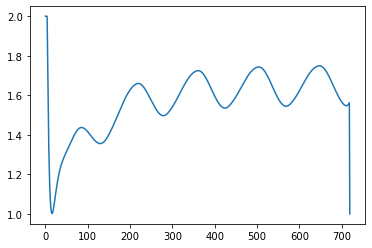

In [8]:
u_HVAC_opt = ans.x # optimal q_HVAC
print('Elapsed time', t_elapsed)
plt.plot(u_HVAC_opt);

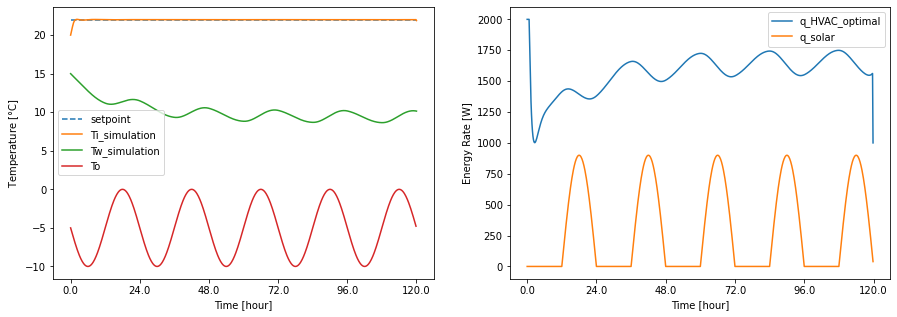

In [9]:
u_HVAC_opt = u_HVAC_opt[:,None]*1000
x, y = simulation(x0, Ad, Bd_HVAC, Bd_dist, Cd, Dd_HVAC, Dd_dist, u_HVAC_opt, u_dist)

Ti_simulation = x[:,0] # Indoor temperature 
Tw_simulation = x[:,1]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(setpoint, label='setpoint', linestyle='--')
ax[0].plot(Ti_simulation, label='Ti_simulation')
ax[0].plot(Tw_simulation, label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(u_HVAC_opt, label='q_HVAC_optimal')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()